# Brain Tumor Detection Using a Convolutional Neural Network


- Importing Necessary Modules


In [1]:
import tensorflow as tf
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


- Data Preparation & Preprocessing


In [2]:
def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(5,5),0)

    thresh = cv2.threshold(gray,45,255,cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh,None,iterations=2)
    thresh = cv2.dilate(thresh,None,iterations=2)

    cnts = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts,key=cv2.contourArea)

    #Find extreme points
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    #crop new image out of original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1],extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1,2,1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top = False, bottom = False, left = False, right = False,
                        labelbottom = False, labeltop = False, labelleft = False, labelright = False)
        
        plt.title("Original Image")

        plt.subplot(1,2,2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top = False, bottom = False, left = False, right = False,
                        labelbottom = False, labeltop = False, labelleft = False, labelright = False)
        
        plt.title("Cropped Image")

        plt.show()

    return new_image       

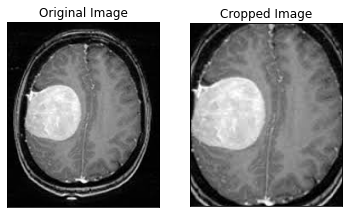

In [3]:
example = cv2.imread("yes/Y1.jpg")
ex_img_new = crop_brain_contour(example,True)

- Load up the data


In [4]:
def load_data(dir_list,image_size):

    #load all images in a directory
    x = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '\\'+filename)   #load the image
            image = crop_brain_contour(image,plot=False)  # crop the brain part and ignore unnecessary part of image
            image = cv2.resize(image,dsize=(image_width, image_height),interpolation=cv2.INTER_CUBIC)  #resizing
            image = image /255   # normalize values
            x.append(image) #convert image to numpy array and append it to X

            if directory[-3:] == "yes":
                y.append([1])
            else:
                y.append([0])
    
    x = np.array(x)
    y = np.array(y)

    x, y = shuffle(x,y)   #shuffle the data

    print(f"Number of examples is: {len(x)}")
    print(f"X shape is: {x.shape}")
    print(f"y shape is: {y.shape}")

    return x,y

In [5]:
augmented_path = "augmented data/"

augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240,240)

x,y = load_data([augmented_yes,augmented_no],(IMG_WIDTH,IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


- Plot sample images


In [6]:
def plot_sample_images(x,y,n=50):

    for label in [0,1]:
        images = x[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n  = 10
        rows_n = int(n/columns_n)

        plt.figure(figsize=(20,10))

        i=1
        for image in n_images:
            plt.subplot(rows_n,columns_n,i)
            plt.imshow(image[0])

            plt.tick_params(axis='both',which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False,labeltop=False,labelleft=False,labelright=False)
            
            i += 1

        label_to_str = lambda label:"Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

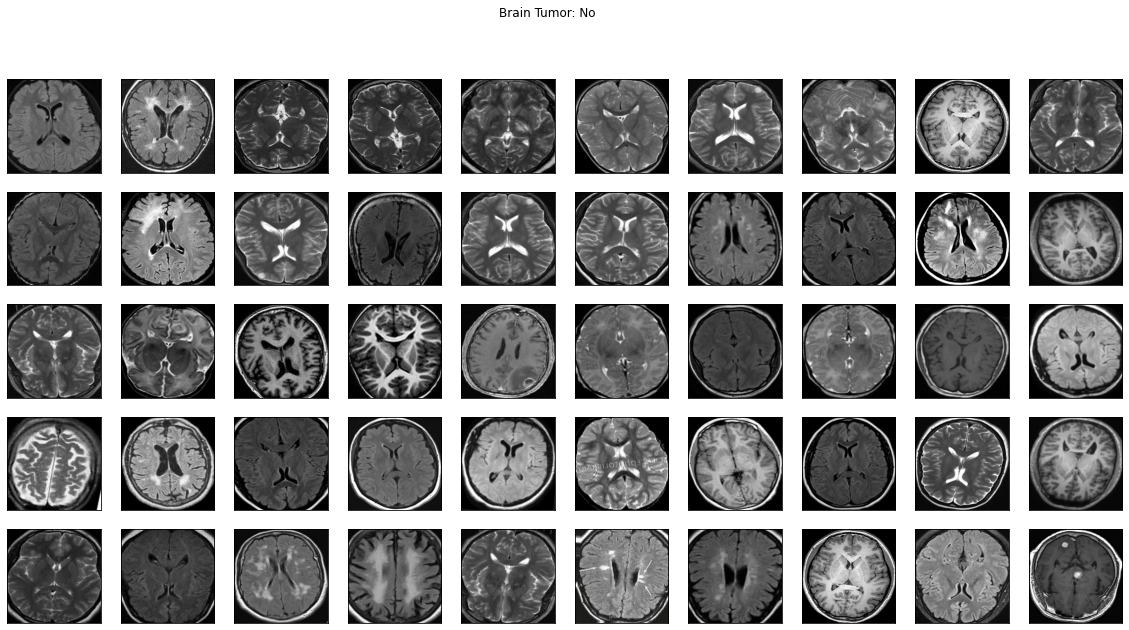

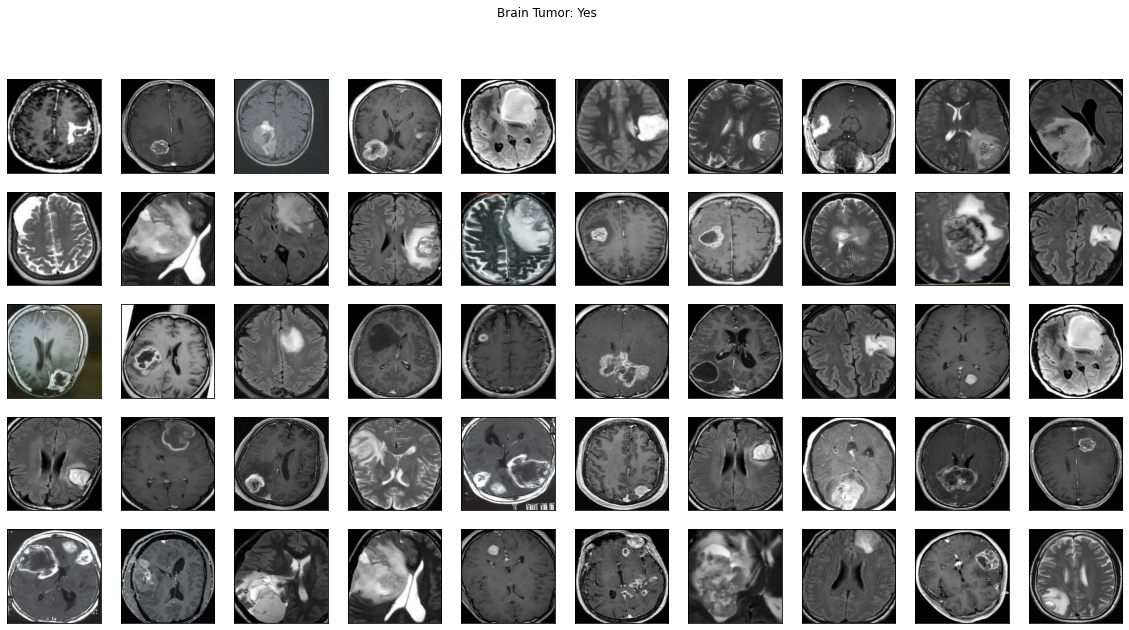

In [7]:
plot_sample_images(x,y)

* Split the data

In [10]:
def split_data(x,y,test_size=0.2):

    x_train, x_test_val, y_train, y_test_val = train_test_split(x,y,test_size=test_size)
    x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5)

    return x_train,y_train,x_val,y_val,x_test,y_test


In [11]:
# 70% data for training
# 15% data for validation
# 15% data for testing

x_train, y_train, x_val, y_val, x_test, y_test = split_data(x,y,test_size=0.3)

In [18]:
print("Number of training samples: ",x_train.shape[0])
print("Number of validation samples: ",x_val.shape[0])
print("Number of test samples: ",x_test.shape[0])
print("-----------------------------------------")
print("x_train shape: ",x_train.shape)
print("y_train shape: ",y_train.shape)
print("x_val shape: ",x_val.shape)
print("y_val shape: ",y_val.shape)
print("x_test shape: ",x_test.shape)
print("y_test shape: ",y_test.shape)

Number of training samples:  1445
Number of validation samples:  310
Number of test samples:  310
-----------------------------------------
x_train shape:  (1445, 240, 240, 3)
y_train shape:  (1445, 1)
x_val shape:  (310, 240, 240, 3)
y_val shape:  (310, 1)
x_test shape:  (310, 240, 240, 3)
y_test shape:  (310, 1)


In [19]:
# for Time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [20]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5,1,0)

    score = f1_score(y_true, y_pred)
    return score

* Build the Model

In [24]:
def build_model(input_shape):

    # Define the input placeholder as a tensor with shape input_shape
    x_input = Input(input_shape)

    # Zero-Padding adds the border of x_input with zeros
    X = ZeroPadding2D((2,2))(x_input)

    # Conv + Normalize + Relu
    X = Conv2D(32,(7,7),strides=(1,1),name="conv0")(X)
    X = BatchNormalization(axis = 3, name='bn0')(X)
    X = Activation('relu')(X)

    #Maxpool
    X = MaxPooling2D((4,4), name="max_pool0")(X)

    #Maxpool2
    X = MaxPooling2D((4,4),name="max_pool1")(X)

    #Flatten
    X = Flatten()(X)

    # Fully Connected
    X = Dense(1,activation="sigmoid",name="fc")(X)

    # creating model
    model = Model(inputs = x_input,outputs=X,name="BrainTumorDetectionModel")

    return model

In [25]:
IMG_SHAPE = (IMG_WIDTH,IMG_HEIGHT,3)

In [26]:
model = build_model(IMG_SHAPE)

In [27]:
model.summary()

Model: "BrainTumorDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 244, 244, 3)       0         
 ing2D)                                                          
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation_1 (Activation)   (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                          

In [28]:
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])

In [29]:
# tensorboard
log_file_name = f'Brain_Tumor_Detection_cnn_{int(time.time())}'
Tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [30]:
#checkpoint
#unique file name that will include the epoch and the validation accuracy
filepath = "cnn-parameter-improvement-{epoch:0.2d}-{val_acc:.2f}"

#Save the model with the best validation accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath,monitor="val_acc",verbose=1,save_best_only=True, mode='max'))

* train the model

In [32]:
start_time = time.time()

model.fit(x=x_train,y=y_train,batch_size=32,epochs=10,validation_data=(x_val,y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/10
46/46 [==============================] - 79s 2s/step - loss: 0.2799 - accuracy: 0.8810 - val_loss: 0.4020 - val_accuracy: 0.8387
Epoch 2/10
46/46 [==============================] - 63s 1s/step - loss: 0.2548 - accuracy: 0.8962 - val_loss: 0.3610 - val_accuracy: 0.8516
Epoch 3/10
46/46 [==============================] - 65s 1s/step - loss: 0.2502 - accuracy: 0.8893 - val_loss: 0.4783 - val_accuracy: 0.7742
Epoch 4/10
46/46 [==============================] - 65s 1s/step - loss: 0.2129 - accuracy: 0.9204 - val_loss: 0.3268 - val_accuracy: 0.8484
Epoch 5/10
46/46 [==============================] - 63s 1s/step - loss: 0.2288 - accuracy: 0.9087 - val_loss: 0.3122 - val_accuracy: 0.8613
Epoch 6/10
46/46 [==============================] - 70s 2s/step - loss: 0.1876 - accuracy: 0.9287 - val_loss: 0.3652 - val_accuracy: 0.8355
Epoch 7/10
46/46 [==============================] - 61s 1s/step - loss: 0.1589 - accuracy: 0.9460 - val_loss: 0.4885 - val_accuracy: 0.7581
Epoch 8/10
46/46 [==

In [35]:
history = model.history.history


In [36]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [38]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss,label="training loss")
    plt.plot(val_loss,label="validation loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_accuracy,label="training accuracy")
    plt.plot(val_accuracy,label="validation accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.show()


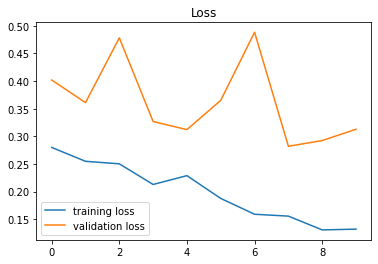

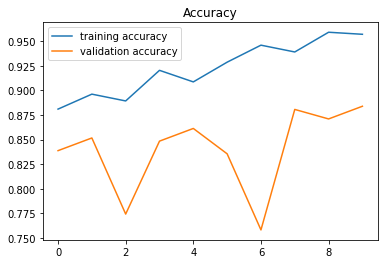

In [39]:
plot_metrics(history)

* Accuracy of the best model on testing data:

In [41]:
loss, accu = model.evaluate(x_test,y_test)

10/10 [==============================] - 4s 358ms/step - loss: 0.3980 - accuracy: 0.8226


In [42]:
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accu}")

Test Loss: 0.3980046212673187
Test Accuracy: 0.8225806355476379


In [77]:
ytest_prob = model.predict(x_test[1:])


10/10 [==============================] - 4s 380ms/step


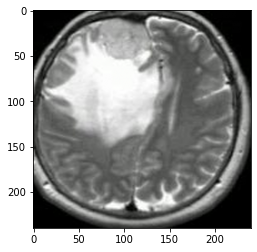

In [81]:
plt.imshow(x_test[3])

In [82]:
ytest_prob[3]

array([0.99122906], dtype=float32)

In [75]:
x_test.shape

(310, 240, 240, 3)

In [83]:
if ytest_prob[3] > 0.5:
    print("Tumor present")
else:
    print("Tumor Ansent")

Tumor present


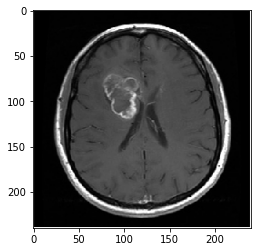

In [143]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the image
image_path = 'yes/Y101.jpg'
target_size = (240, 240)  # Example size, adjust according to your model's input size

image = load_img(image_path, target_size=target_size)
image = img_to_array(image)

image = image / 255.0  # Normalize pixel values to [0, 1]
plt.imshow(image)
image = image.reshape(1, *image.shape)


In [144]:
predictions = model.predict(image)

1/1 [==============================] - 0s 43ms/step


In [145]:
predictions

array([[0.99646646]], dtype=float32)

In [146]:
if predictions > 0.5:
    print("Tumor present")
else:
    print("Tumor Absent")

Tumor present
